#**Avances Trabajo de Grado Samuel Peña**

## **Análisis exploratorio del conjunto de datos**

In [ ]:
import pandas as pd
path = 'https://raw.githubusercontent.com/Sxmuu/Contam-aire/main/Contam-Aire-BOG-2021-2024-Localidades.csv'

# Se lee el archivo csv y se almacena en un DataFrame de Pandas definiendo la coma como separador
df = pd.read_csv(path, sep=',')

In [ ]:
df.head(5)

,DateTime,Estacion,PM25,PM10,NO2,OZONO,SO2,CO,Temperatura,Precipitacion,Vel Viento,Localidad
0,NaN,Bolivia,34.6,59.6,NaN,NaN,NaN,0.62,NaN,NaN,NaN,Engativa
1,NaN,Carvajal - Sevillana,109.0,150.0,NaN,NaN,2.0,NaN,13.5,0.0,0.4,Kennedy
2,NaN,Centro de Alto Rendimiento,25.0,30.9,14.6,0.7,0.3,0.77,12.3,0.0,0.3,Barrios Unidos
3,NaN,Ciudad Bolivar,133.6,180.3,21.7,2.1,8.1,0.96,12.4,NaN,1.4,Ciudad Bolivar
4,NaN,Fontibon,79.5,92.5,16.8,7.8,1.0,0.45,13.3,NaN,NaN,Fontibon


In [ ]:
def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Uniformar nombres (opcional)
    df.columns = [c.strip().replace(' ', '_') for c in df.columns]

    # Reemplazar "----" por NaN
    df = df.replace("----", np.nan)

    # Parsear fecha
    if 'Fecha' in df.columns:
        df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')

    # Forzar numéricos en columnas ambientales si existen
    numeric_cols = ['PM2.5', 'PM10', 'NO2', 'OZONO', 'SO2', 'CO', 'Temperatura', 'Precipitacion', 'Vel_Viento']
    numeric_cols = [c.replace(' ', '_') for c in numeric_cols]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

In [ ]:
df.head(5)

,DateTime,Estacion,PM25,PM10,NO2,OZONO,SO2,CO,Temperatura,Precipitacion,Vel Viento,Localidad
0,NaN,Bolivia,34.6,59.6,NaN,NaN,NaN,0.62,NaN,NaN,NaN,Engativa
1,NaN,Carvajal - Sevillana,109.0,150.0,NaN,NaN,2.0,NaN,13.5,0.0,0.4,Kennedy
2,NaN,Centro de Alto Rendimiento,25.0,30.9,14.6,0.7,0.3,0.77,12.3,0.0,0.3,Barrios Unidos
3,NaN,Ciudad Bolivar,133.6,180.3,21.7,2.1,8.1,0.96,12.4,NaN,1.4,Ciudad Bolivar
4,NaN,Fontibon,79.5,92.5,16.8,7.8,1.0,0.45,13.3,NaN,NaN,Fontibon


In [ ]:
df.shape

(658939, 12)

### Pruebas

In [ ]:
# =========================================
# VISTA EN COLAB: Rachas y Completitud como TABLAS (sin CSVs)
# =========================================
import math
import numpy as np
import pandas as pd
from IPython.display import display

# ---------- Utilidades (independientes) ----------
def _run_lengths_bool(arr: np.ndarray):
    """Longitudes de rachas True consecutivas en un array booleano."""
    if arr.size == 0:
        return []
    diff = np.diff(np.concatenate(([0], arr.view(np.int8), [0])))
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    return (ends - starts).tolist()

def run_length_summary(df: pd.DataFrame, var: str, time_col: str = "Fecha", station_col: str = "Estacion", bins=(3,12,24,72)) -> pd.DataFrame:
    """
    Rachas de NaN por estación para 'var'.
    Devuelve conteos en bins: 1–3, 4–12, 13–24, 25–72, >72 horas + total horas faltantes.
    """
    records = []
    view = df[[station_col, time_col, var]].dropna(subset=[station_col]).copy()
    # Marca NA como booleano (True si falta)
    view["isna"] = view[var].isna()
    for est, g in view.groupby(station_col, dropna=False):
        g = g.sort_values(time_col)
        arr = g["isna"].to_numpy(dtype=bool)
        lengths = _run_lengths_bool(arr)
        if not lengths:
            records.append({"Estacion": est, "total_rachas": 0, "horas_faltantes": 0,
                            "1-3":0, "4-12":0, "13-24":0, "25-72":0, ">72":0})
            continue
        bins_edges = [0, 3, 12, 24, 72, math.inf]
        labels = ["1-3", "4-12", "13-24", "25-72", ">72"]
        counts = {lab: 0 for lab in labels}
        for L in lengths:
            for j in range(len(bins_edges)-1):
                if bins_edges[j] < L <= bins_edges[j+1]:
                    counts[labels[j]] += 1
                    break
        rec = {"Estacion": est, "total_rachas": len(lengths), "horas_faltantes": int(sum(lengths))}
        rec.update(counts)
        records.append(rec)
    out = pd.DataFrame(records).fillna(0).sort_values("horas_faltantes", ascending=False)
    return out

def daily_completeness(df: pd.DataFrame, var: str, station_col: str = "Estacion", time_col: str = "Fecha"):
    """
    Completitud diaria: horas válidas por Estación×Día y resumen por estación.
    Umbral: ok_18h = 1 si horas_validas >= 18.
    Retorna (resumen_por_estacion, detalle_por_estacion_dia).
    """
    # Asegura derivada 'fecha_dia'
    if "fecha_dia" not in df.columns:
        # Si Fecha no tiene tz, igual funciona:
        fecha_dia = pd.to_datetime(df[time_col], errors="coerce").dt.date
    else:
        fecha_dia = df["fecha_dia"]

    g = (
        pd.DataFrame({
            station_col: df[station_col],
            "fecha_dia": fecha_dia,
            var: df[var]
        })
        .groupby([station_col, "fecha_dia"], dropna=False)[var]
        .apply(lambda s: s.notna().sum())
        .reset_index(name="horas_validas")
    )
    g["ok_18h"] = (g["horas_validas"] >= 18).astype(int)

    resumen = (
        g.groupby(station_col, dropna=False)
         .agg(
             dias_ok_18h=("ok_18h", "sum"),
             dias_total=("ok_18h", "count"),
             pct_dias_ok=("ok_18h", lambda x: 100 * x.sum() / max(1, len(x))),
             mediana_horas_validas=("horas_validas", "median"),
             p10_horas_validas=("horas_validas", lambda s: float(np.nanpercentile(s, 10))),
             p90_horas_validas=("horas_validas", lambda s: float(np.nanpercentile(s, 90))),
         )
         .reset_index()
    )
    return resumen, g

def ver_rachas_y_completitud_en_colab(
    df: pd.DataFrame,
    vars_objetivo=("PM2.5","NO2"),
    station_col="Estacion",
    time_col="Fecha",
    max_rows=None  # si quieres recortar la vista en pantalla
):
    """
    Calcula y MUESTRA en pantalla (display) las tablas de:
      - Rachas de NaN por estación.
      - Completitud diaria (resumen y detalle).
    No guarda CSVs. Devuelve un dict con los DataFrames por variable.
    """
    resultados = {}
    for var in vars_objetivo:
        print(f"\n==============================")
        print(f" Variable: {var}")
        print(f"==============================")

        # 1) Rachas
        rl_tbl = run_length_summary(df, var, time_col=time_col, station_col=station_col)
        print("\n▶ Rachas de NaN por estación (ordenado por horas_faltantes):")
        display(rl_tbl if not max_rows else rl_tbl.head(max_rows))

        # 2) Completitud diaria
        resumen, detalle = daily_completeness(df, var, station_col=station_col, time_col=time_col)
        print("\n▶ Completitud diaria - RESUMEN (por estación):")
        display(resumen if not max_rows else resumen.head(max_rows))

        print("\n▶ Completitud diaria - DETALLE (Estación × Día):")
        display(detalle if not max_rows else detalle.head(max_rows))

        resultados[var] = {
            "rachas_df": rl_tbl,
            "completitud_resumen_df": resumen,
            "completitud_detalle_df": detalle
        }
    return resultados

# ---------- EJEMPLO DE USO ----------
# Asume que ya tienes un DataFrame 'df' con columnas: 'Fecha', 'Estacion', 'PM2.5', 'NO2', etc.
# Si no, carga tu Excel antes (read_excel) y asegúrate de parsear fechas:
#
# import pandas as pd
# df = pd.read_excel("tus_datos.xlsx", sheet_name=0, engine="openpyxl")
# df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")
#
# Opcional: normaliza nombres de estación
# df["Estacion"] = (df["Estacion"].astype(str).str.replace("\u00A0"," ", regex=False)
#                                    .str.replace(r"\s+"," ", regex=True).str.strip())

# Llama a la función para ver tablas en Colab:
# resultados_tablas = ver_rachas_y_completitud_en_colab(df, vars_objetivo=("PM2.5","NO2"), station_col="Estacion", time_col="Fecha", max_rows=None)


In [ ]:
resultados_tablas = ver_rachas_y_completitud_en_colab(
    df,
    vars_objetivo=("PM2.5","NO2"),
    station_col="Estacion",
    time_col="Fecha",
    max_rows=None  # o pon 50 para mostrar solo las primeras 50 filas de cada tabla
)



 Variable: PM2.5

▶ Rachas de NaN por estación (ordenado por horas_faltantes):


,Estacion,total_rachas,horas_faltantes,1-3,4-12,13-24,25-72,>72
1,Carvajal - Sevillana,130,13917,80,25,9,7,9
11,Movil 7ma,122,9139,80,18,9,9,6
17,Usaquen,166,5101,134,21,2,3,6
0,Bolivia,117,4658,87,20,3,4,3
12,Movil Fontibon,269,3623,218,34,6,4,7
4,Colina,247,3012,160,45,16,17,9
8,Kennedy,233,2861,195,18,9,4,7
15,Suba,197,2102,151,17,8,17,4
9,Las Ferias,260,1948,218,22,5,9,6
18,Usme,130,1528,78,24,9,15,4



▶ Completitud diaria - RESUMEN (por estación):


,Estacion,dias_ok_18h,dias_total,pct_dias_ok,mediana_horas_validas,p10_horas_validas,p90_horas_validas
0,Bolivia,1264,1461,86.516085,24.0,0.0,24.0
1,Carvajal - Sevillana,862,1461,59.000684,24.0,0.0,24.0
2,Centro de Alto Rendimiento,1406,1461,96.235455,24.0,23.0,24.0
3,Ciudad Bolivar,1437,1461,98.357290,24.0,23.0,24.0
4,Colina,1312,1461,89.801506,24.0,17.0,24.0
5,Fontibon,1401,1461,95.893224,24.0,23.0,24.0
6,Guaymaral,1389,1461,95.071869,24.0,23.0,24.0
7,Jazmin,1412,1461,96.646133,24.0,23.0,24.0
8,Kennedy,1333,1461,91.238877,24.0,21.0,24.0
9,Las Ferias,1373,1461,93.976728,24.0,22.0,24.0



▶ Completitud diaria - DETALLE (Estación × Día):


,Estacion,fecha_dia,horas_validas,ok_18h
0,Bolivia,2021-01-01,23,1
1,Bolivia,2021-01-02,24,1
2,Bolivia,2021-01-03,24,1
3,Bolivia,2021-01-04,24,1
4,Bolivia,2021-01-05,24,1
...,...,...,...,...
27754,Usme,2024-12-27,24,1
27755,Usme,2024-12-28,24,1
27756,Usme,2024-12-29,24,1
27757,Usme,2024-12-30,24,1



 Variable: NO2

▶ Rachas de NaN por estación (ordenado por horas_faltantes):


,Estacion,total_rachas,horas_faltantes,1-3,4-12,13-24,25-72,>72
1,Carvajal - Sevillana,1,35040,0,0,0,0,1
11,Movil 7ma,1,35040,0,0,0,0,1
0,Bolivia,145,16143,100,26,5,9,5
10,MinAmbiente,201,5935,164,29,2,1,5
12,Movil Fontibon,221,5542,178,25,9,5,4
16,Tunal,452,4422,358,83,2,4,5
6,Guaymaral,572,4316,375,170,5,13,9
7,Jazmin,248,2514,176,45,13,10,4
9,Las Ferias,450,2480,369,59,7,9,6
13,Puente Aranda,282,2401,238,30,4,6,4



▶ Completitud diaria - RESUMEN (por estación):


,Estacion,dias_ok_18h,dias_total,pct_dias_ok,mediana_horas_validas,p10_horas_validas,p90_horas_validas
0,Bolivia,778,1461,53.251198,22.0,0.0,24.0
1,Carvajal - Sevillana,0,1461,0.000000,0.0,0.0,0.0
2,Centro de Alto Rendimiento,1381,1461,94.524298,24.0,22.0,24.0
3,Ciudad Bolivar,1431,1461,97.946612,24.0,22.0,24.0
4,Colina,1362,1461,93.223819,24.0,21.0,24.0
5,Fontibon,1382,1461,94.592745,24.0,22.0,24.0
6,Guaymaral,1265,1461,86.584531,24.0,15.0,24.0
7,Jazmin,1341,1461,91.786448,24.0,20.0,24.0
8,Kennedy,1373,1461,93.976728,24.0,22.0,24.0
9,Las Ferias,1354,1461,92.676249,24.0,20.0,24.0



▶ Completitud diaria - DETALLE (Estación × Día):


,Estacion,fecha_dia,horas_validas,ok_18h
0,Bolivia,2021-01-01,0,0
1,Bolivia,2021-01-02,0,0
2,Bolivia,2021-01-03,0,0
3,Bolivia,2021-01-04,12,0
4,Bolivia,2021-01-05,24,1
...,...,...,...,...
27754,Usme,2024-12-27,0,0
27755,Usme,2024-12-28,0,0
27756,Usme,2024-12-29,0,0
27757,Usme,2024-12-30,0,0


# **Análisis**

In [ ]:
# Cantidad de estaciones únicas por localidad
estaciones_por_localidad = (
    df.groupby("Localidad")["Estacion"]
      .nunique()
      .reset_index(name="n_estaciones")
      .sort_values("n_estaciones", ascending=False)
)
print(estaciones_por_localidad)

         Localidad  n_estaciones
9             Suba             3
3         Engativa             2
6    Puente Aranda             2
5          Kennedy             2
4         Fontibon             2
1        Chapinero             1
2   Ciudad Bolivar             1
0   Barrios Unidos             1
7    San Cristobal             1
8         Santa Fe             1
10      Tunjuelito             1
11         Usaquen             1
12            Usme             1


In [ ]:
import pandas as pd
import numpy as np

# Columnas a evaluar (ajústalas si quieres otras)
cols_medidas = ["PM25","PM10","NO2","OZONO","SO2","CO","Temperatura","Precipitacion","Vel Viento"]
# Preservar el orden del dataset
cols = [c for c in df.columns if c in cols_medidas]

n = len(df)

# Nulos y Ceros (ceros robusto para cols no numéricas)
nulos = df[cols].isna().sum()

def count_zeros(s):
    if pd.api.types.is_numeric_dtype(s):
        return (s == 0).sum()
    s_num = pd.to_numeric(s, errors="coerce")
    return (s_num == 0).sum()

ceros = pd.Series({c: count_zeros(df[c]) for c in cols}, index=cols)

# Construir tabla respetando el orden del df
tabla_calidad = pd.concat([nulos, ceros], axis=1)
tabla_calidad.columns = ["Nulos", "Ceros"]
tabla_calidad["Total_Filas"] = n
tabla_calidad["% Nulos"] = (tabla_calidad["Nulos"] / n).round(5)
tabla_calidad["% Ceros"] = (tabla_calidad["Ceros"] / n).round(5)

# Reordenar según el orden del df y pasar Variable a columna
tabla_calidad = (
    tabla_calidad.loc[cols]
    .reset_index()
    .rename(columns={"index": "Variable"})
)

print("=== Resumen de nulidad y ceros (orden del dataset) ===")
print(tabla_calidad.to_string(index=False))


=== Resumen de nulidad y ceros (orden del dataset) ===
     Variable  Nulos  Ceros  Total_Filas  % Nulos  % Ceros
         PM25  51073  31517       658939  0.07751  0.04783
         PM10  67298   4042       658939  0.10213  0.00613
          NO2 122285    697       658939  0.18558  0.00106
        OZONO 174918   4619       658939  0.26545  0.00701
          SO2 342954   2522       658939  0.52046  0.00383
           CO  98503    809       658939  0.14949  0.00123
  Temperatura 167237     12       658939  0.25380  0.00002
Precipitacion 128873 451577       658939  0.19558  0.68531
   Vel Viento 205680    689       658939  0.31214  0.00105


In [ ]:
tabla_calidad['Variable']

,Variable
0,PM25
1,PM10
2,NO2
3,OZONO
4,SO2
5,CO
6,Temperatura
7,Precipitacion
8,Vel Viento


In [ ]:
# =========================================
# Añadir lat/lon por estación a tu df
# (usa tu lista de coordenadas)
# =========================================
import pandas as pd
import unicodedata, re

# 1) Tu lista de estaciones con coordenadas
coords_list = [
    ("Guaymaral", 4.78375, -74.04414),
    ("Usaquen", 4.71035, -74.03042),
    ("Suba", 4.76125, -74.09346),
    ("Bolivia", 4.73580, -74.12589),
    ("Las Ferias", 4.69070, -74.08249),
    ("Centro de alto rendimiento", 4.65847, -74.08396),
    ("Movil 7ma", 4.64519, -74.06156),
    ("MinAmbiente", 4.62549, -74.06698),
    ("Fontibon", 4.67825, -74.14382),
    ("Puente Aranda", 4.63177, -74.11749),
    ("Kennedy", 4.62505, -74.16133),
    ("Carvajal - Sevillana", 4.59583, -74.14850),
    ("Tunal", 4.57623, -74.13096),
    ("San Cristobal", 4.57256, -74.08381),
    ("Jazmin", 4.60850, -74.11494),
    ("Usme", 4.53206, -74.11714),
    ("Bosa", 4.60561, -74.20406),
    ("Ciudad Bolivar", 4.57781, -74.16628),
    ("Colina", 4.73719, -74.06948),
    ("Movil Fontibon", 4.66800, -74.14850),
]

coords_df = pd.DataFrame(coords_list, columns=["Estacion", "lat", "lon"])

# 2) Función para normalizar nombres (quita tildes, espacios raros, NBSP, casefold)
def norm_name(s: str) -> str:
    if s is None:
        return None
    s = str(s).replace("\u00A0", " ")               # NBSP -> espacio normal
    s = unicodedata.normalize("NFKD", s)            # separa tildes
    s = "".join(ch for ch in s if not unicodedata.combining(ch))  # quita tildes
    s = s.lower().strip()
    s = re.sub(r"\s+", " ", s)                      # colapsa espacios
    return s

coords_df["est_norm"] = coords_df["Estacion"].map(norm_name)

# 3) Aplica la misma normalización a tu df y fusiona
#    (asumimos que ya tienes df con columna 'Estacion')
df = df.copy()
df["est_norm"] = df["Estacion"].map(norm_name)

df = df.merge(
    coords_df[["est_norm", "lat", "lon"]],
    on="est_norm",
    how="left"
)

# 4) Revisión rápida
faltantes = df.loc[df["lat"].isna(), "Estacion"].drop_duplicates().tolist()
if faltantes:
    print("⚠️ Estaciones sin match de lat/lon (revisa ortografía):")
    for s in faltantes:
        print(" -", s)
else:
    print("✅ Todas las estaciones mapeadas con lat/lon")

# (Opcional) ya puedes borrar la columna de normalización si quieres:
# df = df.drop(columns=["est_norm"])


✅ Todas las estaciones mapeadas con lat/lon


In [ ]:
df

,DateTime,Estacion,PM25,PM10,NO2,OZONO,SO2,CO,Temperatura,Precipitacion,Vel Viento,Localidad,est_norm,lat,lon
0,01/01/2021 01:00,Bolivia,34.6,59.6,NaN,NaN,NaN,0.62,NaN,NaN,NaN,Engativa,bolivia,4.73580,-74.12589
1,01/01/2021 01:00,Carvajal - Sevillana,109.0,150.0,NaN,NaN,2.00,NaN,13.5,0.0,0.4,Kennedy,carvajal - sevillana,4.59583,-74.14850
2,01/01/2021 01:00,Centro de Alto Rendimiento,25.0,30.9,14.6,0.7,0.30,0.77,12.3,0.0,0.3,Barrios Unidos,centro de alto rendimiento,4.65847,-74.08396
3,01/01/2021 01:00,Ciudad Bolivar,133.6,180.3,21.7,2.1,8.10,0.96,12.4,NaN,1.4,Ciudad Bolivar,ciudad bolivar,4.57781,-74.16628
4,01/01/2021 01:00,Fontibon,79.5,92.5,16.8,7.8,1.00,0.45,13.3,NaN,NaN,Fontibon,fontibon,4.67825,-74.14382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658934,01/01/2024 00:00,San Cristobal,31.0,86.0,10.4,NaN,NaN,0.40,11.9,0.0,2.1,San Cristobal,san cristobal,4.57256,-74.08381
658935,01/01/2024 00:00,Suba,NaN,25.4,14.0,0.6,0.70,0.74,13.6,0.0,0.4,Suba,suba,4.76125,-74.09346
658936,01/01/2024 00:00,Tunal,8.7,107.0,9.8,78.0,NaN,1.06,NaN,326.0,1.9,Tunjuelito,tunal,4.57623,-74.13096
658937,01/01/2024 00:00,Usaquen,0.0,5.1,2.6,27.0,0.61,3.20,137.0,12.6,16.8,Usaquen,usaquen,4.71035,-74.03042


In [ ]:
#Selecciona registros con localidad = "La Candelaria"
df[df['Localidad'] == 'La Candelaria']


,DateTime,Estacion,PM25,PM10,NO2,OZONO,SO2,CO,Temperatura,Precipitacion,Vel Viento,Localidad


### **Estadísticos sugeridos**

In [ ]:
df_resultado = (
    df.groupby("Localidad")
      .agg(
          media=("PM25", "mean"),
          mediana=("PM25", "median"),
          desv_std=("PM25", lambda s: s.std(ddof=1)),
          varianza=("PM25", lambda s: s.var(ddof=1)),
          iqr=("PM25", lambda s: s.quantile(0.75) - s.quantile(0.25)),
          skewness=("PM25", lambda s: skew(s.dropna()) if s.dropna().size > 1 else np.nan),
          kurtosis=("PM25", lambda s: kurtosis(s.dropna()) if s.dropna().size > 1 else np.nan),
          min=("PM25", "min"),
          p25=("PM25", lambda s: s.quantile(0.25)),
          p50=("PM25", lambda s: s.quantile(0.50)),
          p75=("PM25", lambda s: s.quantile(0.75)),
          max=("PM25", "max"),
          n_obs=("PM25", lambda s: s.dropna().size),
      )
      .sort_index()
      .round(1)
)


In [ ]:
df_resultado

,media,mediana,desv_std,varianza,iqr,skewness,kurtosis,min,p25,p50,p75,max,n_obs
Localidad,,,,,,,,,,,,,
Barrios Unidos,13.6,11.0,10.2,104.6,14.4,1.1,1.4,0.0,5.3,11.0,19.7,84.0,33819
Chapinero,16.2,13.5,12.0,144.2,16.0,1.2,1.9,0.0,6.9,13.5,22.9,134.0,25900
Ciudad Bolivar,18.0,15.4,12.3,150.8,17.1,1.2,3.0,0.0,8.0,15.4,25.1,139.3,34352
Engativa,14.7,12.8,9.8,96.8,13.2,1.1,1.9,0.0,7.0,12.8,20.2,106.0,63473
Fontibon,19.8,17.3,12.4,154.1,16.0,1.2,2.6,0.0,10.4,17.3,26.4,162.4,65218
Kennedy,20.7,19.0,16.5,271.2,22.1,1.0,2.3,0.0,8.0,19.0,30.1,188.0,53302
Puente Aranda,14.0,11.5,12.2,147.9,16.7,1.2,1.8,0.0,4.3,11.5,21.0,101.8,68008
San Cristobal,12.4,9.0,11.1,123.8,12.0,1.6,3.8,0.0,5.0,9.0,17.0,137.0,33830
Santa Fe,13.9,11.0,11.1,123.1,14.0,1.5,3.6,0.0,6.0,11.0,20.0,146.0,34219


In [ ]:
import pandas as pd
import numpy as np

# 1) Parsear DateTime a datetime (sin tocar tus datos)
dt = pd.to_datetime(df["DateTime"], dayfirst=True, errors="coerce")
df = df.assign(Anio=dt.dt.year)

# 2) Asegurar PM25 numérica
df["PM25"] = pd.to_numeric(df["PM25"], errors="coerce")

# 3) Promedios 2021–2024 por Localidad
years = [2021, 2022, 2023, 2024]
tabla = (
    df[df["Anio"].isin(years)]
      .groupby(["Localidad", "Anio"])["PM25"].mean()
      .unstack("Anio")                        # columnas = años
      .reindex(columns=years)                 # orden fijo de columnas
      .round(2)
)

# 4) Renombrar columnas y dejar Localidad como columna
tabla.columns = [f"Promedio PM 2.5 {y} [ug/m3]" for y in tabla.columns]
tabla = tabla.reset_index()

print(tabla)


Empty DataFrame
Columns: [Localidad, Promedio PM 2.5 2021 [ug/m3], Promedio PM 2.5 2022 [ug/m3], Promedio PM 2.5 2023 [ug/m3], Promedio PM 2.5 2024 [ug/m3]]
Index: []


In [ ]:
import pandas as pd
import numpy as np
import re

# Copia de trabajo
s = df["DateTime"].copy()

# --- Limpieza básica de strings ---
s_str = (
    s.astype(str)
     .str.replace("\u00A0", " ", regex=False)   # NBSP -> espacio normal
     .str.replace(r"\s+", " ", regex=True)      # colapsar espacios
     .str.strip()
)

# --- Normalizar '24:00' -> '00:00' y marcar dónde ocurrió ---
mask24 = s_str.str.contains(r"\b24:00\b", na=False)
s_norm = s_str.str.replace(r"\b24:00\b", "00:00", regex=True)

# --- Parseo A: cadenas (acepta dd-mm-YYYY HH:MM o dd/mm/..., dayfirst) ---
# 'format="mixed"' (pandas ≥2.0) permite formatos variados fila a fila.
try:
    dt_text = pd.to_datetime(s_norm, dayfirst=True, format="mixed", errors="coerce")
except TypeError:
    # fallback si tu pandas no soporta 'mixed'
    dt_text = pd.to_datetime(s_norm, dayfirst=True, errors="coerce")

# Sumar 1 día solo a las filas que originalmente tenían 24:00
dt_text = dt_text + pd.to_timedelta(mask24.astype(int), unit="D")

# --- Parseo B: seriales de Excel (e.g., 44197.5) ---
serial = pd.to_numeric(s, errors="coerce")  # solo numéricos
dt_serial = pd.to_datetime(serial, unit="D", origin="1899-12-30", errors="coerce")

# --- Elegir el parseo que resultó válido en cada fila ---
dt = dt_text.fillna(dt_serial)

# Diagnóstico rápido (opcional)
print("Fechas válidas tras limpieza:", dt.notna().sum())
print("Ejemplos parseados:\n", pd.concat([s.loc[dt.notna()].head(3), dt.loc[dt.notna()].head(3)], axis=1))

# --- Construir la tabla 2021–2024 por Localidad ---
df["PM25"] = pd.to_numeric(df["PM25"], errors="coerce")
df["Localidad"] = df["Localidad"].astype(str).str.strip()
df["Anio"] = dt.dt.year

years = [2021, 2022, 2023, 2024]
tabla = (
    df.loc[df["Anio"].isin(years) & df["PM25"].notna() & df["Localidad"].ne("")]
      .groupby(["Localidad", "Anio"])["PM25"].mean()
      .unstack("Anio")
      .reindex(columns=years)
      .round(2)
      .reset_index()
)

tabla.columns = ["Localidad"] + [f"Promedio PM 2.5 {y} [ug/m3]" for y in years]
print(tabla)


Fechas válidas tras limpieza: 0
Ejemplos parseados:
 Empty DataFrame
Columns: [DateTime, DateTime]
Index: []
Empty DataFrame
Columns: [Localidad, Promedio PM 2.5 2021 [ug/m3], Promedio PM 2.5 2022 [ug/m3], Promedio PM 2.5 2023 [ug/m3], Promedio PM 2.5 2024 [ug/m3]]
Index: []


### **Gráficos**

#### **Boxplot**

In [ ]:
#Deslpliega valores unicos de la columna localidad de mi dataset:
df['Localidad'].unique()

array(['Engativa', 'Kennedy', 'Barrios Unidos', 'Ciudad Bolivar',
       'Fontibon', 'Suba', 'Puente Aranda', 'La Candelaria', 'Chapinero',
       'San Cristobal', 'Tunjuelito', 'Usaquen', 'Usme'], dtype=object)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipython-input-3385799979.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0, ha='center')


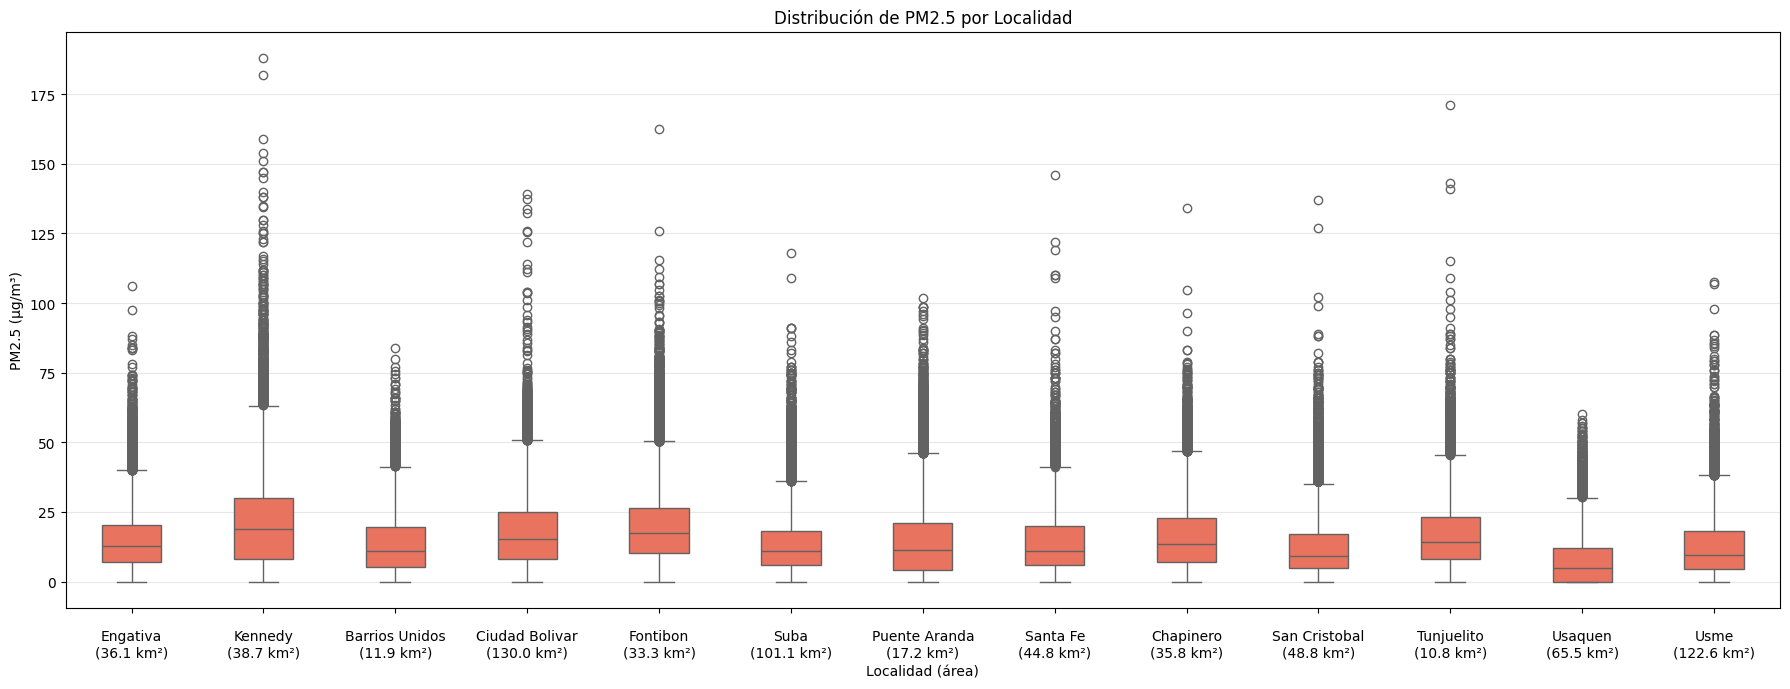

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Orden "oficial" (sin tildes), según tu lista
orden_localidades = [
    'Engativa', 'Kennedy', 'Barrios Unidos', 'Ciudad Bolivar',
    'Fontibon', 'Suba', 'Puente Aranda', 'Santa Fe',
    'Chapinero', 'San Cristobal', 'Tunjuelito', 'Usaquen', 'Usme'
]

areas_km2 = {
    'Engativa': 36.06,
    'Kennedy': 38.72,
    'Barrios Unidos': 11.92,
    'Ciudad Bolivar': 130.00,
    'Fontibon': 33.32,
    'Suba': 101.07,
    'Puente Aranda': 17.24,
    'Santa Fe': 44.82,
    'Chapinero': 35.78,
    'San Cristobal': 48.83,
    'Tunjuelito': 10.79,
    'Usaquen': 65.54,
    'Usme': 122.63,
}

presentes = [loc for loc in orden_localidades if loc in df['Localidad'].unique()]

faltan = [loc for loc in presentes if areas_km2.get(loc) in (None, float('nan'))]
if faltan:
    print(f"⚠️ Falta definir el área (km²) para: {', '.join(faltan)}")

# 1) LIENZO más ancho
fig, ax = plt.subplots(figsize=(18, 7))

# 2) Cajas más angostas (más “aire” entre categorías)
sns.boxplot(
    x='Localidad', y='PM25', data=df,
    color='tomato', order=presentes, width=0.45, ax=ax
)

# Etiquetas: "Localidad\n(XX.X km²)"
labels = []
for loc in presentes:
    a = areas_km2.get(loc)
    etiqueta = f"{loc}\n({a:.1f} km²)" if isinstance(a, (int, float)) else f"{loc}\n(s/d)"
    labels.append(etiqueta)

# 3) Más espacio para etiquetas y mejor legibilidad
ax.set_xticklabels(labels, rotation=0, ha='center')
ax.tick_params(axis='x', labelsize=10, pad=12)
fig.subplots_adjust(bottom=0.25)  # más margen inferior por el salto de línea

ax.set_title('Distribución de PM2.5 por Localidad')
ax.set_ylabel('PM2.5 (µg/m³)')
ax.set_xlabel('Localidad (área)')
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


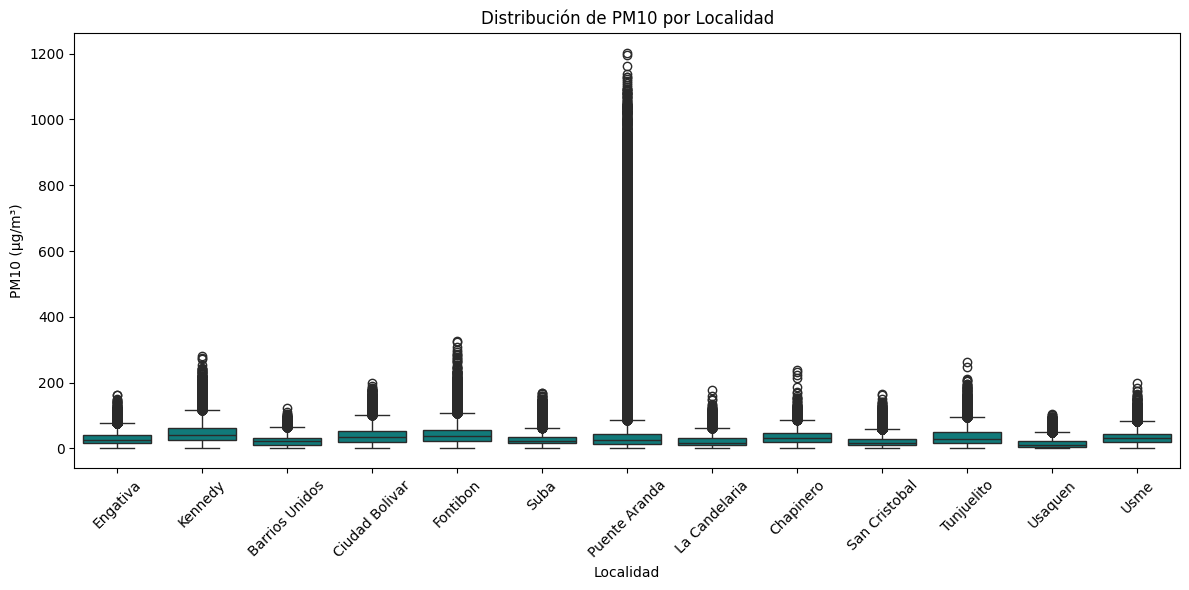

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Localidad', y='PM10', data=df, color="darkcyan")
plt.xticks(rotation=45)
plt.title('Distribución de PM10 por Localidad')
plt.ylabel('PM10 (µg/m³)')
plt.xlabel('Localidad')
plt.tight_layout()
plt.show()

#### **Histogramas**

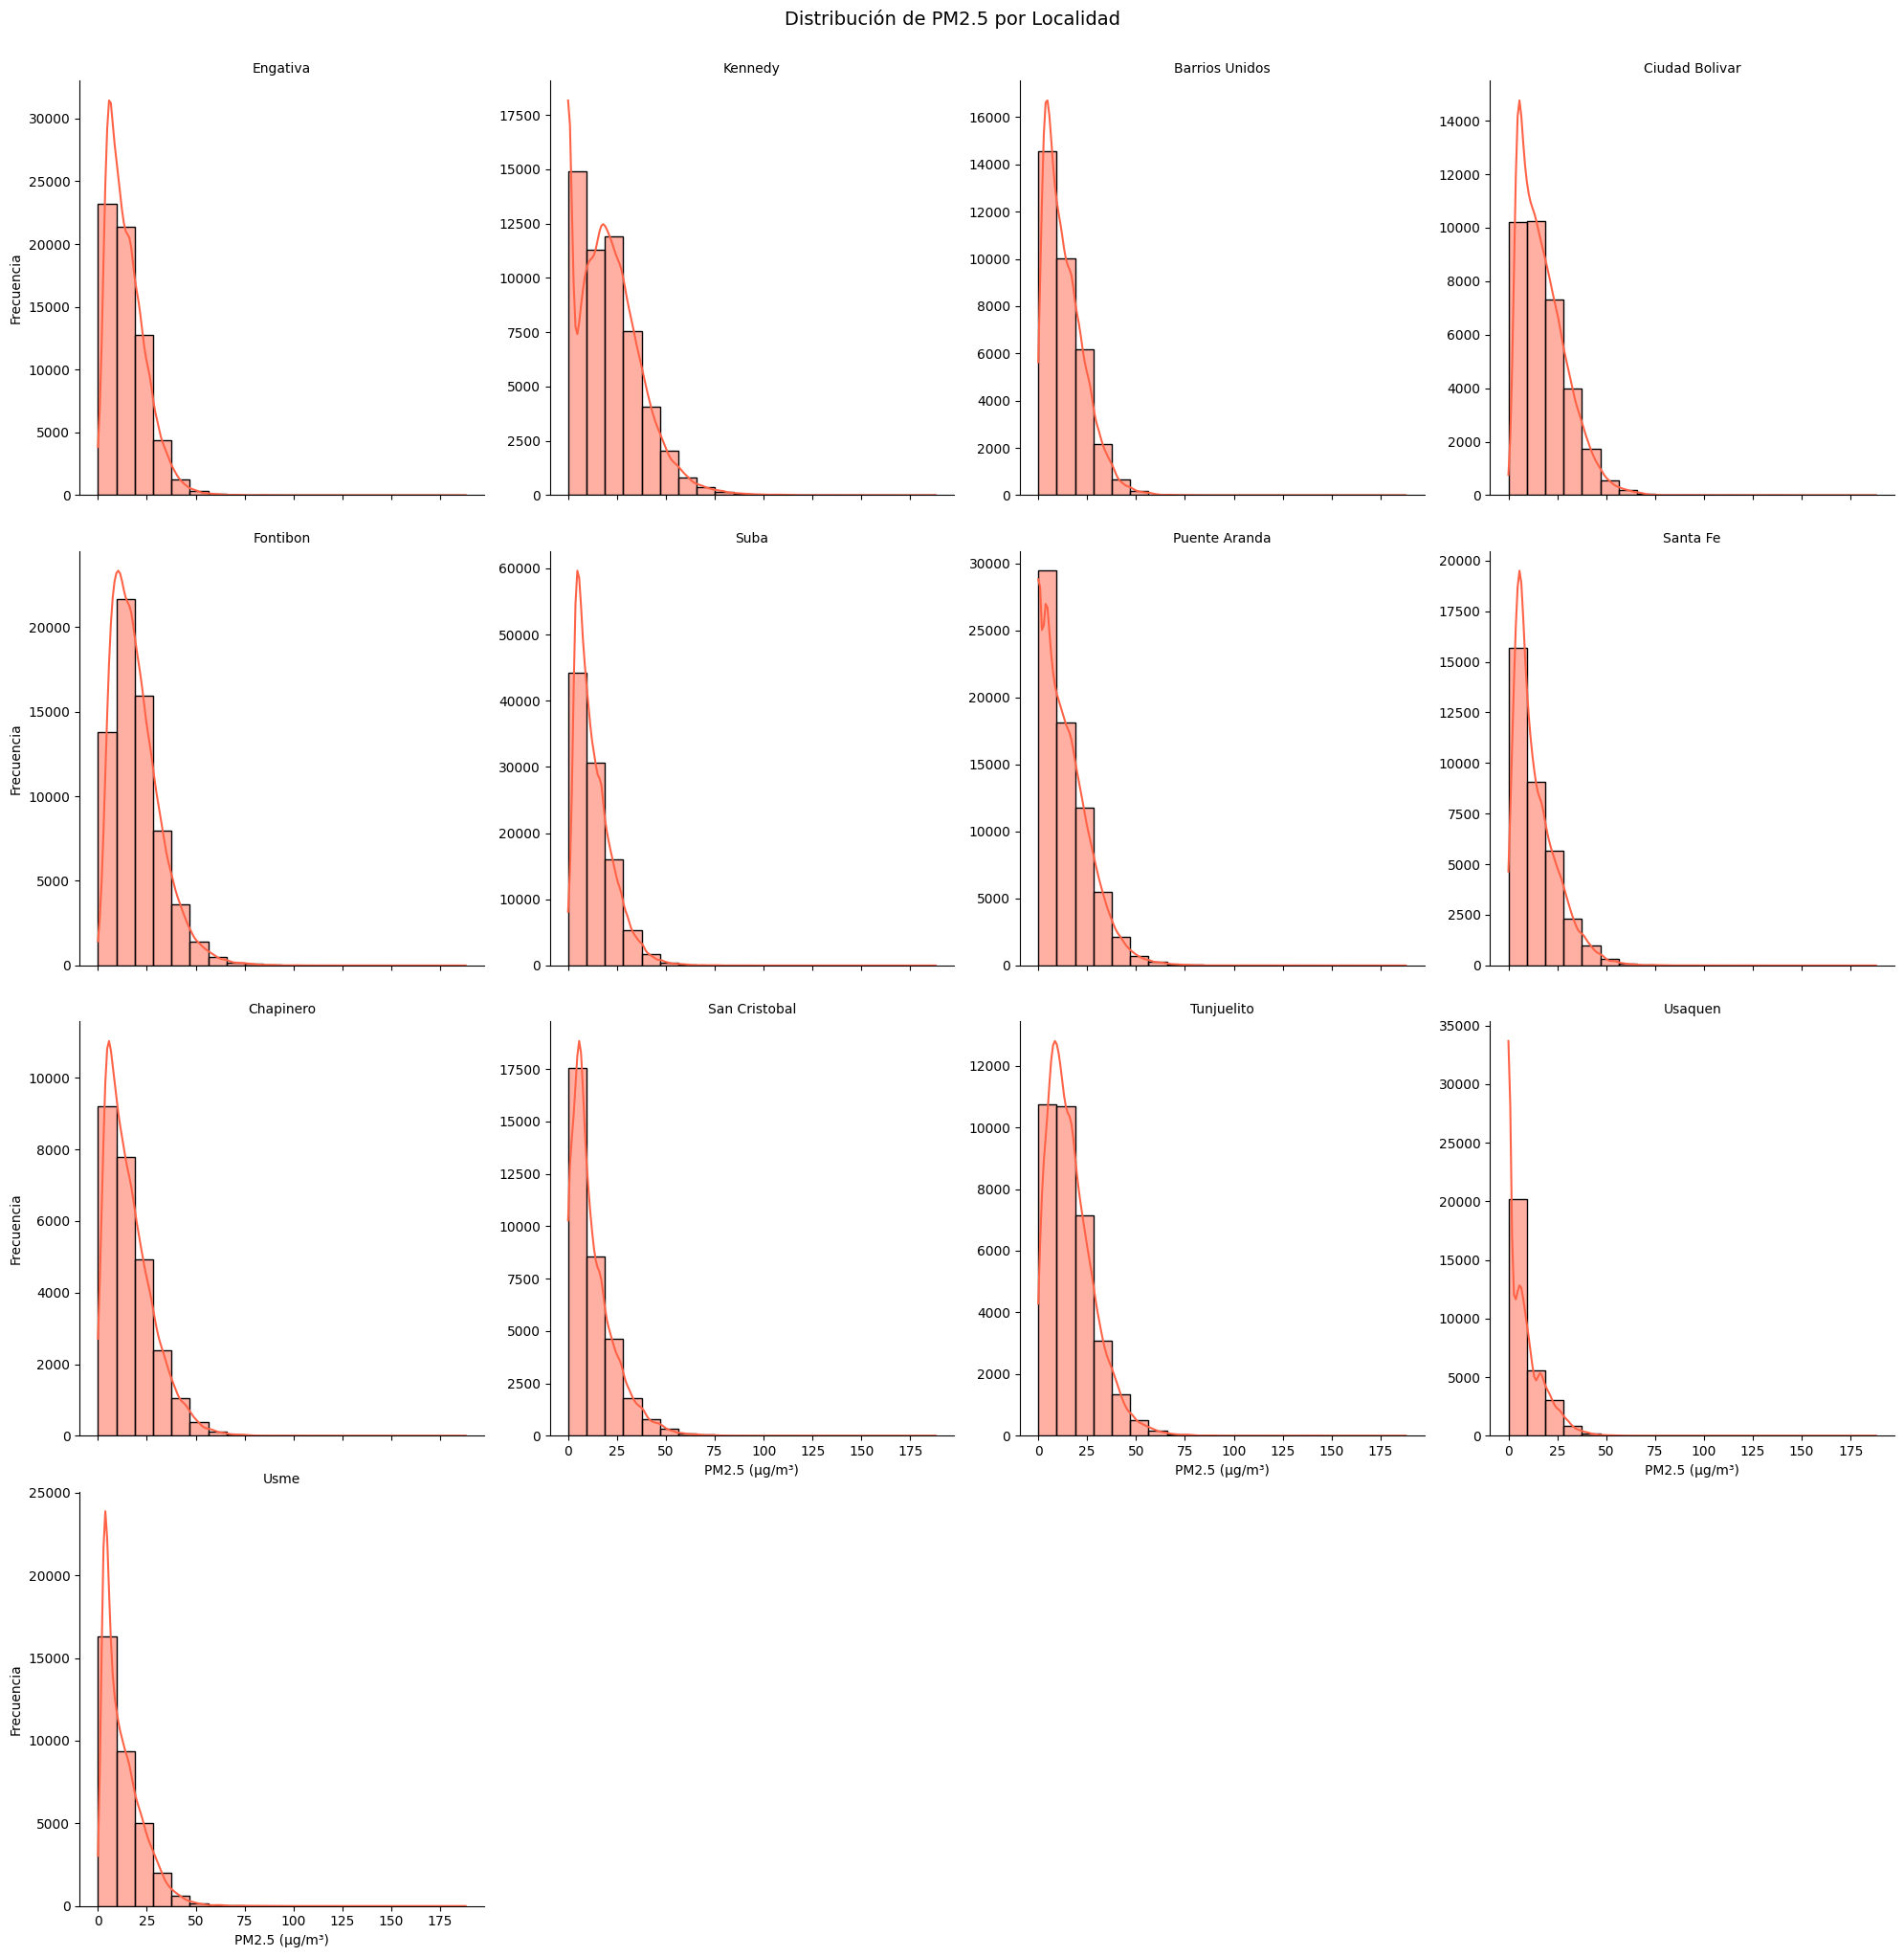

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# (Opcional) orden fijo si lo necesitas
orden_localidades = [
    'Engativa','Kennedy','Barrios Unidos','Ciudad Bolivar','Fontibon',
    'Suba','Puente Aranda','Santa Fe','Chapinero','San Cristobal',
    'Tunjuelito','Usaquen','Usme'
]
presentes = [l for l in orden_localidades if l in df['Localidad'].unique()]

g = sns.displot(
    data=df.dropna(subset=["PM25","Localidad"]),
    x="PM25",
    col="Localidad",
    col_wrap=4,
    col_order=presentes,          # quita este parámetro si no te importa el orden
    bins=20,
    kde=True,
    color="tomato",
    facet_kws=dict(sharex=True, sharey=False, margin_titles=True)
)

g.set_axis_labels("PM2.5 (µg/m³)", "Frecuencia")
g.set_titles(col_template="{col_name}")
g.fig.suptitle("Distribución de PM2.5 por Localidad", y=1.02, fontsize=14)
plt.show()


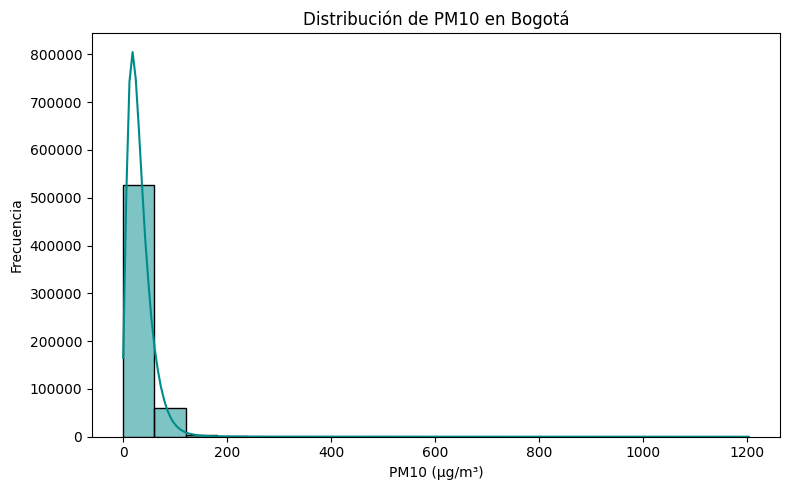

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['PM10'], bins=20, kde=True, color='darkcyan')
plt.title('Distribución de PM10 en Bogotá')
plt.xlabel('PM10 (µg/m³)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

#### **Distribución temporal**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
df['DateTime'].unique

<bound method Series.unique of 0         01/01/2021 01:00
1         01/01/2021 01:00
2         01/01/2021 01:00
3         01/01/2021 01:00
4         01/01/2021 01:00
                ...       
658934    01/01/2024 00:00
658935    01/01/2024 00:00
658936    01/01/2024 00:00
658937    01/01/2024 00:00
658938    01/01/2024 00:00
Name: DateTime, Length: 658939, dtype: object>

ValueError: Axis limits cannot be NaN or Inf

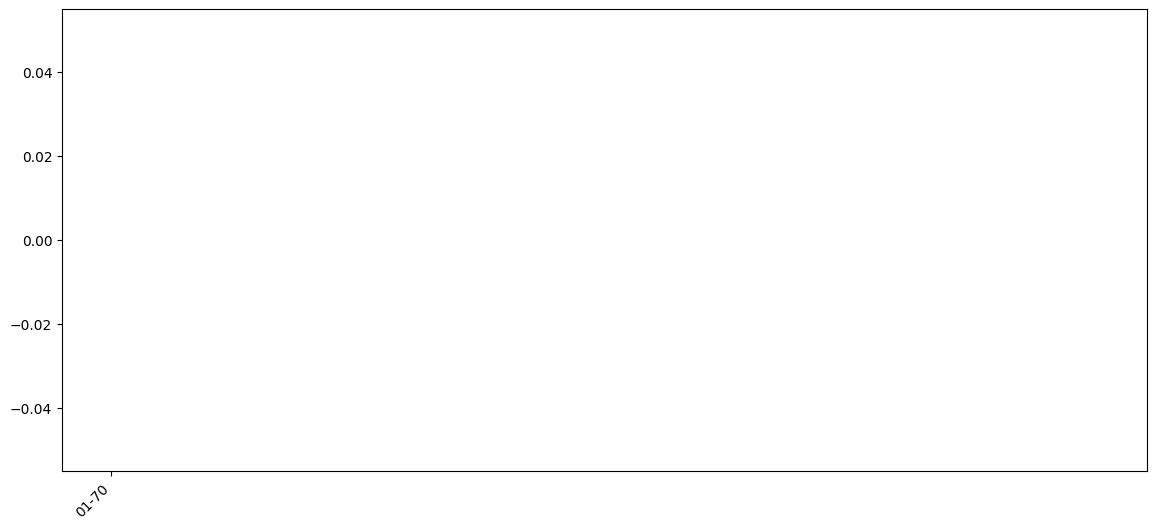

In [ ]:
# ... después de construir pm25_mensual (Mes es datetime al inicio de cada mes)
# Asegurar formato datetime (ya corregido por ti antes)
df["Fecha"] = pd.to_datetime(df["DateTime"], dayfirst=True, errors="coerce")

# Crear columna mensual desde la columna de fechas
df["Mes"] = df["Fecha"].dt.to_period("M").dt.to_timestamp()

# Agrupación por mes
pm25_mensual = (
    df.groupby("Mes")["PM25"]
      .mean()
      .reset_index()
)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Plot ---
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(pm25_mensual["Mes"], pm25_mensual["PM25"], marker="o", color="tomato")

# --- Configuración del eje X ---
# Un tick cada mes
loc = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(loc)

# Formato: mes-año en dos dígitos (ej: 01-21, 02-21, ...)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%y"))

# Rotar etiquetas para legibilidad
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Limitar el eje X a los datos reales
ax.set_xlim(pm25_mensual["Mes"].min(), pm25_mensual["Mes"].max())

# --- Estética ---
ax.set_title("PM2.5 Promedio Mensual en 13 localidades de (2021–2024)", fontsize=14)
ax.set_xlabel("Mes-Año")
ax.set_ylabel("PM2.5 (µg/m³)")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


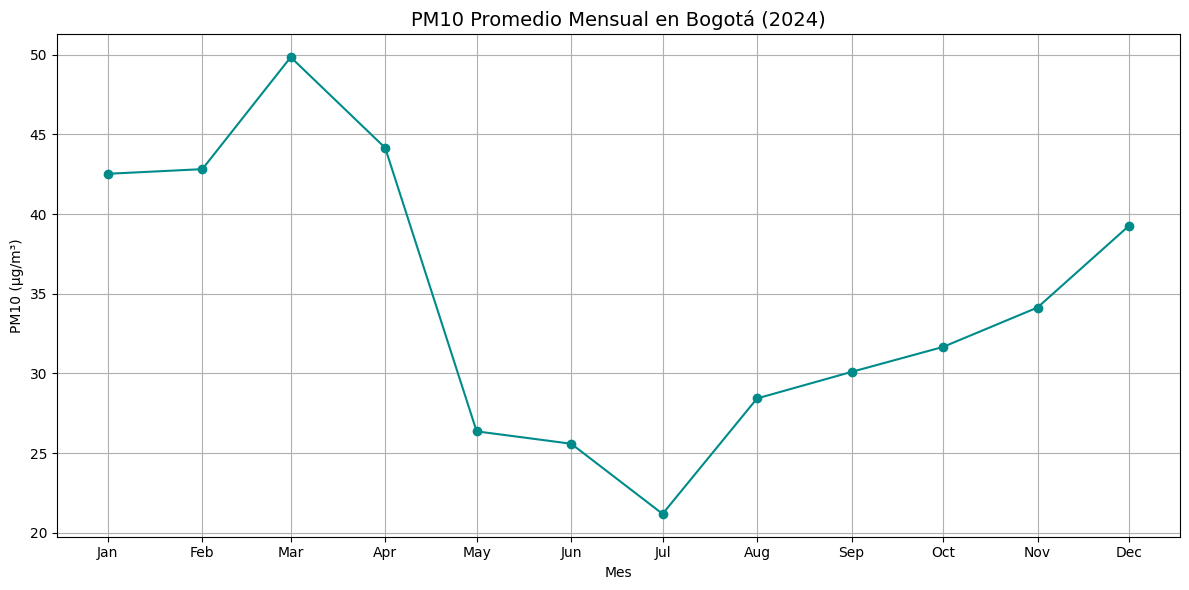

In [ ]:
# Asegurar formato datetime
df["Fecha"] = pd.to_datetime(df["Fecha"])
df["Mes"] = df["Fecha"].dt.to_period("M").dt.to_timestamp()

pm10_mensual = (
    df.groupby("Mes")["PM10"]
      .mean()
      .reset_index()
)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(pm10_mensual["Mes"], pm10_mensual["PM10"], marker="o", color="darkcyan")

# Formato del eje x solo con nombre del mes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

ax.set_title("PM10 Promedio Mensual en Bogotá (2024)", fontsize=14)
ax.set_xlabel("Mes")
ax.set_ylabel("PM10 (µg/m³)")
ax.grid(True)

plt.tight_layout()
plt.show()


## **Creación de mapas**

### **Creación de un mapa simple con shapefile**

In [ ]:
pip install matplotlib_scalebar

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib_scalebar.scalebar import ScaleBar

ModuleNotFoundError: No module named 'matplotlib_scalebar'

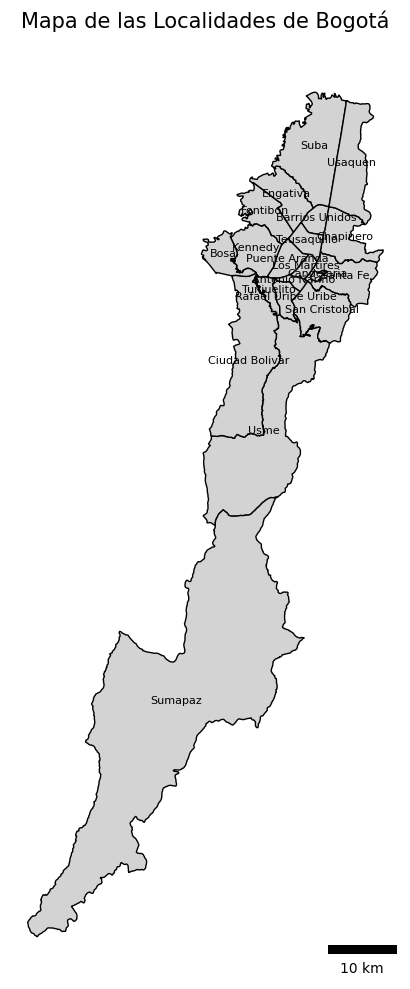

In [ ]:
gdf = gpd.read_file("/content/drive/MyDrive/Tesis")

gdf = gdf.to_crs(epsg=3116)

fig, ax = plt.subplots(figsize=(8, 10))
gdf.plot(ax=ax, color="lightgrey", edgecolor="black")

ax.set_title("Mapa de las Localidades de Bogotá", fontsize=15)
ax.axis("off")

for idx, row in gdf.iterrows():
    plt.annotate(
        text=row["Nombre_de_l"].title(),
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha="center",
        fontsize=8,
        color="black"
    )

scalebar = ScaleBar(1, units="m", dimension="si-length", location="lower right", scale_loc='bottom')
ax.add_artist(scalebar)

plt.tight_layout()
plt.show()

### **Creación de un mapa de calor con la distribución de contaminante PM2.5 por localidad**

In [ ]:
#Conexión a mi drive
from google.colab import drive
drive.mount('/content/drive')
gdf = gpd.read_file("/content/drive/MyDrive/Tesis")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 18.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.cm import ScalarMappable
from matplotlib_scalebar.scalebar import ScaleBar
import unidecode, math

# ---------- 1) Fechas -> Año ----------
if not np.issubdtype(df["DateTime"].dtype, np.datetime64):
    fecha = pd.to_datetime(df["DateTime"], dayfirst=True, errors="coerce")
else:
    fecha = df["DateTime"]

df = df.assign(Anio=fecha.dt.year)
df = df.dropna(subset=["Anio"])  # si no, years podría quedar vacío

# ---------- 2) PM2.5 promedio por (Año, Localidad) ----------
pm25_anio_loc = (
    df.groupby(["Anio", "Localidad"], as_index=False)["PM25"]
      .mean()
      .rename(columns={"PM25": "PM25_media"})
)

# Si no hay datos tras el groupby, abortar limpiamente
years = sorted(pm25_anio_loc["Anio"].dropna().unique().astype(int))
if len(years) == 0:
    print("No hay años válidos en el dataset (revisa el parseo de DateTime o filtros previos).")
    raise SystemExit

# ---------- 3) Normalizar nombres y preparar gdf base ----------
gdf_base = gdf.copy()
gdf_base["Nombre_de_l_norm"] = gdf_base["Nombre_de_l"].apply(lambda x: unidecode.unidecode(str(x).strip().upper()))
pm25_anio_loc["Localidad_norm"] = pm25_anio_loc["Localidad"].apply(lambda x: unidecode.unidecode(str(x).strip().upper()))
gdf_base = gdf_base.to_crs(epsg=3116)  # metros

# ---------- 4) Escala de color global (comparable entre años) ----------
vals = pm25_anio_loc["PM25_media"].dropna().to_numpy()
if vals.size == 0:
    print("No hay valores numéricos de PM2.5 para mapear.")
    raise SystemExit

# percentiles robustos; fallback a min/max; evitar vmin==vmax
if vals.size >= 10:
    vmin, vmax = np.percentile(vals, [2, 98])
else:
    vmin, vmax = float(np.min(vals)), float(np.max(vals))
if vmin == vmax:
    vmax = vmin + 1e-6

norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = "OrRd"

# ---------- 5) Subplots por año ----------
n = len(years)
ncols = 2 if n > 1 else 1
nrows = math.ceil(n / ncols)     # <- garantiza nrows >= 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5.2 * nrows))
axes = np.atleast_1d(axes).ravel()

for i, y in enumerate(years):
    ax = axes[i]
    sel = pm25_anio_loc.loc[pm25_anio_loc["Anio"] == y, ["Localidad_norm", "PM25_media"]]
    gdf_y = gdf_base.merge(sel, left_on="Nombre_de_l_norm", right_on="Localidad_norm", how="left")

    gdf_y.plot(
        column="PM25_media",
        cmap=cmap,
        norm=norm,
        linewidth=0.3,
        edgecolor="gray",
        legend=False,
        ax=ax,
        missing_kwds=dict(color="lightgrey", edgecolor="gray", hatch="///", label="Sin dato")
    )
    ax.set_title(f"PM2.5 promedio – {y}", fontsize=12)
    ax.axis("off")

# Ocultar ejes sobrantes si #años es impar
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

# ---------- 6) Colorbar única ----------
sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.tolist(), fraction=0.03, pad=0.02)
cbar.set_label("PM2.5 promedio (µg/m³)")

# ---------- 7) Barra de escala (en el último eje con datos) ----------
last_ax = axes[[ax.has_data() for ax in axes].index(True) if any(ax.has_data() for ax in axes) else 0]
last_ax.add_artist(ScaleBar(dx=1, units="m", location="lower right"))

plt.suptitle("PM2.5 promedio por Localidad — Mapas por Año", y=0.92, fontsize=14)
plt.tight_layout()
plt.show()


No hay años válidos en el dataset (revisa el parseo de DateTime o filtros previos).


SystemExit: 

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## **BenMAP**

Se han realizado avances en términos de exploración de la herramienta, donde se ha realizado una prueba piloto con los datos de Colombia que proporciona la EPA.

Asimismo, se cargó el mismo shapefile utilizado para los mapas de este Notebook en BenMAP-CE, dando como resultado esta visualización, útil de cara al objetivo final: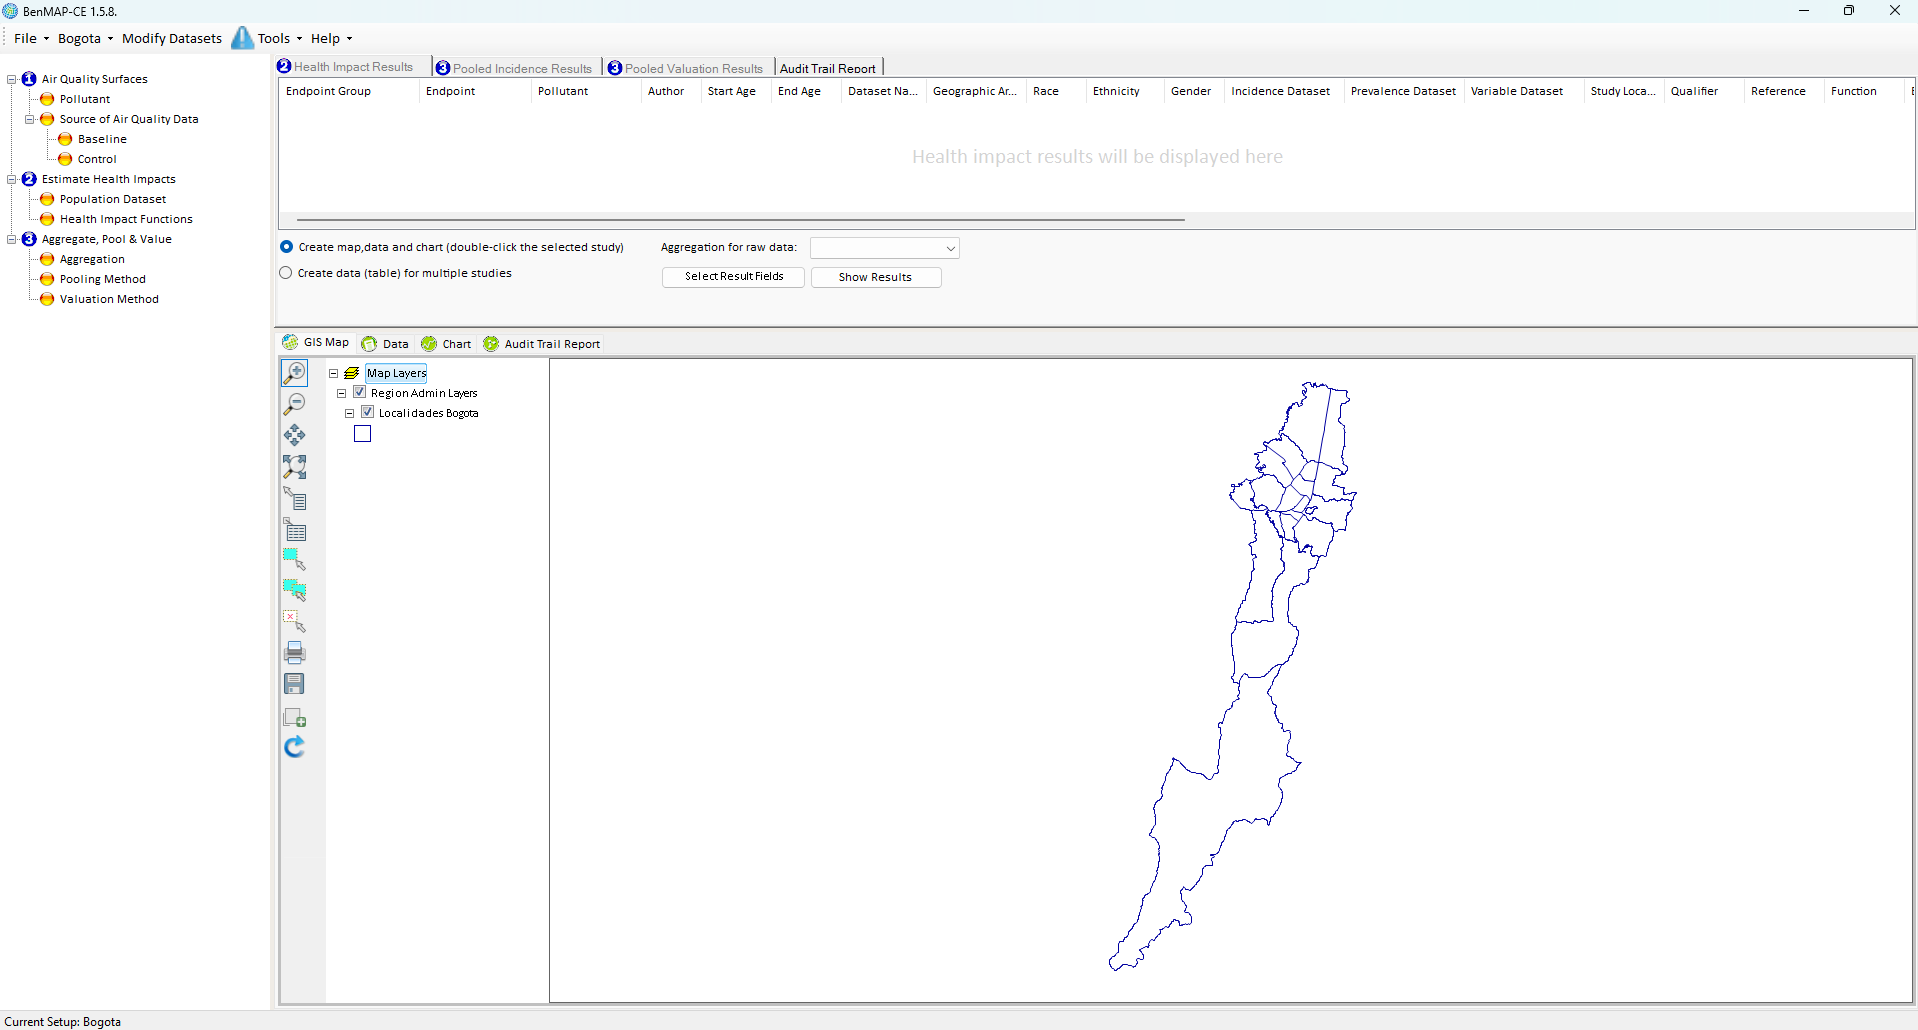